In [15]:
import os
import pandas as pd

DATA_DIR = r"F:\DevProjects\Projects\Solar_Flare_Prediction\data\SDOBenchmark-data-full"

TRAIN_IMG_DIR = os.path.join(DATA_DIR, "training")
TEST_IMG_DIR  = os.path.join(DATA_DIR, "test")

TRAIN_CSV = os.path.join(TRAIN_IMG_DIR, "train.csv")
TEST_CSV  = os.path.join(TEST_IMG_DIR,  "test.csv")

print("TRAIN_CSV:", TRAIN_CSV)
print("TEST_CSV :", TEST_CSV)
print("Train CSV exists:", os.path.exists(TRAIN_CSV))
print("Test  CSV exists:", os.path.exists(TEST_CSV))


TRAIN_CSV: F:\DevProjects\Projects\Solar_Flare_Prediction\data\SDOBenchmark-data-full\training\train.csv
TEST_CSV : F:\DevProjects\Projects\Solar_Flare_Prediction\data\SDOBenchmark-data-full\test\test.csv
Train CSV exists: True
Test  CSV exists: True


In [16]:
train_df = pd.read_csv(
    TRAIN_CSV,
    header=None,
    names=["id", "start", "end", "peak_flux"]
)
test_df = pd.read_csv(
    TEST_CSV,
    header=None,
    names=["id", "start", "end", "peak_flux"]
)

# convert peak_flux to numeric
train_df["peak_flux"] = pd.to_numeric(train_df["peak_flux"], errors="coerce")
test_df["peak_flux"]  = pd.to_numeric(test_df["peak_flux"],  errors="coerce")

# drop rows where peak_flux is NaN (optional but safer)
train_df = train_df.dropna(subset=["peak_flux"]).reset_index(drop=True)

print(train_df.head())
print(train_df.dtypes)


                            id                          start  \
0  11390_2012_01_05_17_06_01_0  2012-01-05 05:06:01.000000000   
1  11390_2012_01_05_17_19_01_0  2012-01-05 05:19:01.000000000   
2  11390_2012_01_05_17_19_01_1  2012-01-06 05:19:00.000000000   
3  11390_2012_01_06_17_20_58_0  2012-01-06 05:20:58.000000000   
4  11390_2012_01_04_07_22_01_0  2012-01-03 19:22:01.000000000   

                             end     peak_flux  
0  2012-01-05 17:06:01.000000000  8.000000e-07  
1  2012-01-05 17:19:01.000000000  1.647059e-06  
2  2012-01-06 17:19:00.000000000  1.647059e-06  
3  2012-01-06 17:20:58.000000000  1.164706e-06  
4  2012-01-04 07:22:01.000000000  2.235294e-06  
id            object
start         object
end           object
peak_flux    float64
dtype: object


In [17]:
def flux_to_class(flux):
    if pd.isna(flux):
        return None
    if flux >= 1e-4:
        return "X"
    elif flux >= 1e-5:
        return "M"
    elif flux >= 1e-6:
        return "C"
    elif flux >= 1e-7:
        return "B"
    else:
        return "A"

train_df["class"] = train_df["peak_flux"].apply(flux_to_class)
print(train_df["class"].value_counts().sort_index())


class
A    3651
B    1280
C    2891
M     479
X      35
Name: count, dtype: int64


In [18]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def get_sample_dir(img_root, sample_id):
    # sample_id like "11390_2012_01_05_17_19_01_0"
    parts = sample_id.split("_", 1)
    region = parts[0]
    rest   = parts[1]
    return os.path.join(img_root, region, rest)

CHANNEL_TAGS = [
    "94", "131", "171", "193", "211",
    "304", "335", "1700", "continuum", "magnetogram"
]

def parse_file(fname):
    # Example filename: 2012-01-05T051901__171.jpg
    base = fname[:-4]             # drop .jpg
    ts_str, tag = base.split("__")
    return ts_str, tag

def load_sample_from_id(img_root, sample_id):
    sample_dir = get_sample_dir(img_root, sample_id)
    fnames = sorted(os.listdir(sample_dir))

    # group files by timestamp
    by_ts = {}
    for f in fnames:
        ts_str, tag = parse_file(f)
        by_ts.setdefault(ts_str, {})[tag] = f

    # pick up to 4 earliest timestamps
    ts_list = sorted(by_ts.keys())[:4]

    imgs = []
    for ts in ts_list:
        tag2file = by_ts[ts]
        for tag in CHANNEL_TAGS:
            if tag in tag2file:
                img_path = os.path.join(sample_dir, tag2file[tag])
                img = Image.open(img_path).convert("L")
                imgs.append(np.array(img))
            else:
                # missing channel -> zeros
                imgs.append(np.zeros((256, 256), dtype=np.uint8))

    imgs = np.array(imgs)   # shape (40, 256, 256)
    return imgs


(40, 256, 256)


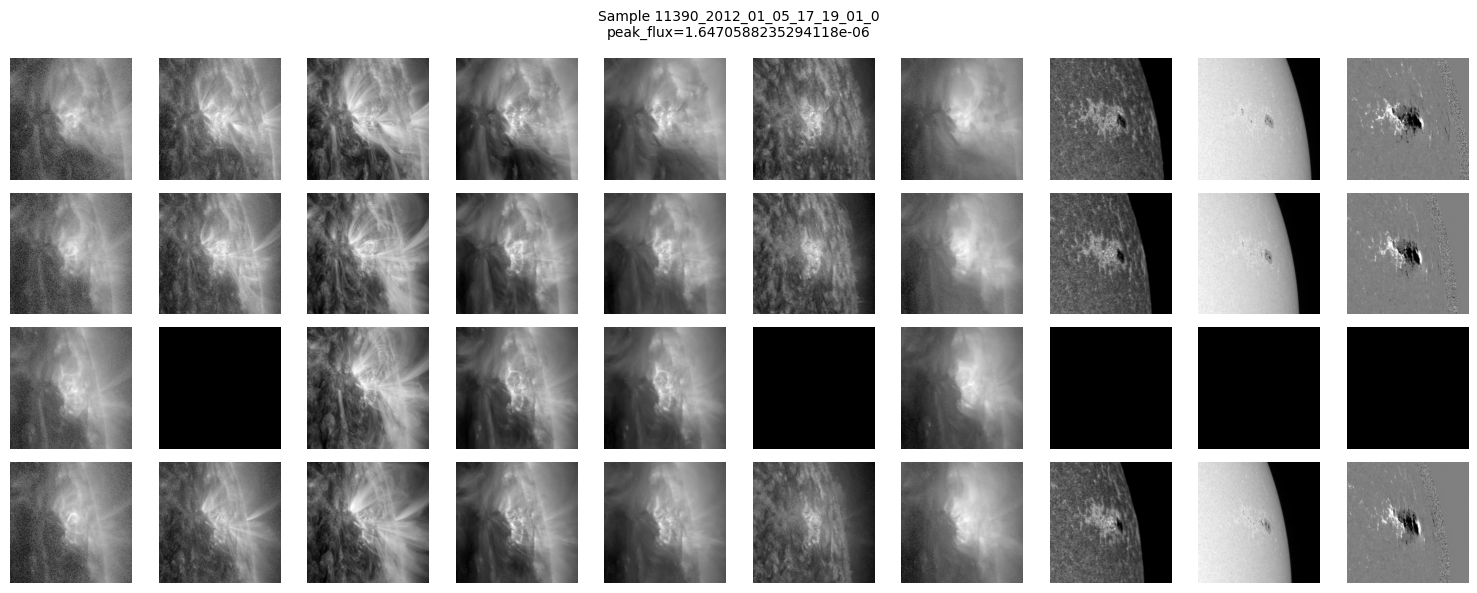

In [19]:
def plot_sample_grid(imgs, sample_id, peak_flux=None):
    """
    imgs: (40, 256, 256)
    4 timesteps x 10 channels.
    """
    fig, axes = plt.subplots(4, 10, figsize=(15, 6))
    fig.suptitle(f"Sample {sample_id}\npeak_flux={peak_flux}", fontsize=10)

    for i in range(4):
        for j in range(10):
            idx = i * 10 + j
            ax = axes[i, j]
            ax.imshow(imgs[idx], cmap="gray")
            ax.axis("off")

    plt.tight_layout()
    plt.show()

# test on one sample
sample_id = train_df.iloc[1]["id"]
sample_imgs = load_sample_from_id(TRAIN_IMG_DIR, sample_id)
print(sample_imgs.shape)
plot_sample_grid(sample_imgs, sample_id, peak_flux=train_df.iloc[1]["peak_flux"])


Min, max, mean: 0 183 84.69717407226562


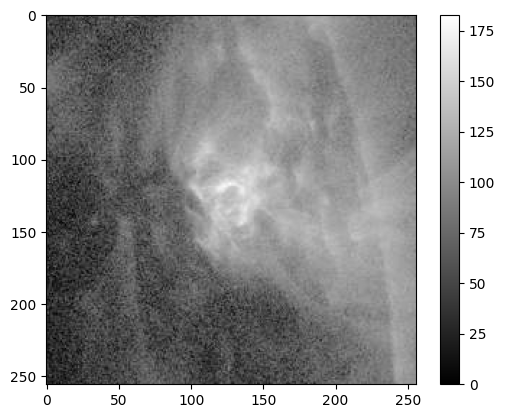

In [20]:
img_arr = sample_imgs[0]
print("Min, max, mean:", img_arr.min(), img_arr.max(), img_arr.mean())
plt.imshow(img_arr, cmap="gray")
plt.colorbar()
plt.show()


In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import time

def extract_simple_features(imgs):
    feats = []
    for i in range(40):
        arr = imgs[i]
        feats.append(arr.mean())
        feats.append(arr.std())
    return np.array(feats)

N_SAMPLES = 200  # start small so it’s fast

X = []
y = []

start_time = time.time()
for idx, (_, row) in enumerate(train_df.iloc[:N_SAMPLES].iterrows(), start=1):
    sid = row["id"]
    imgs = load_sample_from_id(TRAIN_IMG_DIR, sid)
    X.append(extract_simple_features(imgs))
    y.append(row["peak_flux"])
    if idx % 20 == 0:
        print(f"Processed {idx}/{N_SAMPLES} samples")

X = np.vstack(X)
y = np.array(y)

print("Feature matrix shape:", X.shape, "Time:", round(time.time() - start_time, 1), "s")

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
print("MAE:", mean_absolute_error(y_val, y_pred))


Processed 20/200 samples
Processed 40/200 samples
Processed 60/200 samples
Processed 80/200 samples
Processed 100/200 samples
Processed 120/200 samples
Processed 140/200 samples
Processed 160/200 samples
Processed 180/200 samples
Processed 200/200 samples
Feature matrix shape: (200, 80) Time: 91.8 s
MAE: 1.4399357359943977e-06
